In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageOps, ImageFont
import matplotlib.pyplot as plt

In [12]:
!pip install einops

In [13]:
from einops import rearrange

In [14]:
def empty_cell(dim=32):
    base = np.full((dim,dim), 255, dtype=np.uint8)
    base[0, :] = 0
    base[dim-1, :] = 0
    base[dim-1, :] = 0
    base[:, 0] = 0
    base[:, dim-1] = 0
    return base

In [15]:

(12* 110.333333) / ((11 + 13/16) / 10)

1120.8465574603176

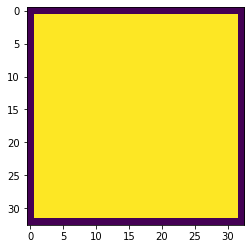

In [16]:
plt.imshow(empty_cell(33))

In [17]:
def edge_cell(dim=32):
    filled = Image.fromarray(np.zeros((dim,dim), dtype=np.uint8))
    draw = ImageDraw.Draw(filled)
    s = dim
    o = 2
    stroke = 4
    ss = dim - stroke
    draw.ellipse( (0+o, 0+o, s-o, s-o), fill=(255,), outline=(0,))
    draw.ellipse( (0+o+stroke, 0+o+stroke, ss-o, ss-o), fill=(0,), outline=(0,))
    del draw
    return filled

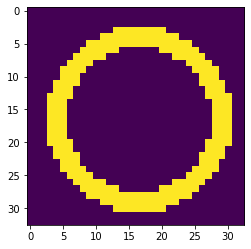

In [18]:
plt.imshow(edge_cell(33))

In [19]:
img = Image.open("mask_v2_fill.png")
im = np.array(img)[:, 1:] # np.array(img)

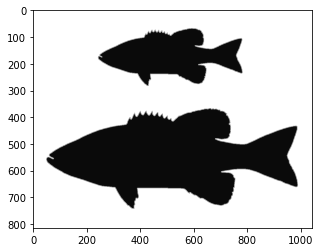

In [20]:
plt.imshow(im)

In [46]:
im.shape

(814, 1043, 4)

In [61]:
ims = np.array(im[:810, :1040, 3])
inner_fill = np.array(im[:810, :1040, 0])
ims.shape

(810, 1040)

In [62]:
tile_size = 10

In [63]:
chunked = rearrange(ims, "(i x) (j y) -> i j x y ", x=tile_size, y=tile_size)
chunked_inner_fill = rearrange(inner_fill, "(i x) (j y) -> i j x y ", x=tile_size, y=tile_size)

In [64]:
chunked.shape

(81, 104, 10, 10)

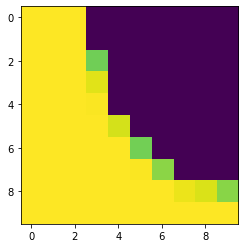

In [65]:
plt.imshow(chunked[40,50])

In [74]:
chunked[40,50]

array([[255, 255, 255,   0,   0,   0,   0,   0,   0,   0],
       [255, 255, 255,   0,   0,   0,   0,   0,   0,   0],
       [255, 255, 255, 200,   0,   0,   0,   0,   0,   0],
       [255, 255, 255, 244,   0,   0,   0,   0,   0,   0],
       [255, 255, 255, 254,   0,   0,   0,   0,   0,   0],
       [255, 255, 255, 255, 239,   0,   0,   0,   0,   0],
       [255, 255, 255, 255, 255, 201,   0,   0,   0,   0],
       [255, 255, 255, 255, 255, 254, 211,   0,   0,   0],
       [255, 255, 255, 255, 255, 255, 255, 248, 241, 210],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

In [80]:
thres = 20 # 128
tcif = (chunked_inner_fill > thres)
tif = (inner_fill > thres)

threshed_chunks_inner_fill = tcif.astype(np.uint8)
threshed_chunks = np.logical_and((chunked > thres), np.logical_not(tcif)).astype(np.uint8)

threshed_inner_fill = tif.astype(np.uint8)
threshed = np.logical_and((ims > thres), np.logical_not(tif)).astype(np.uint8)


In [81]:
threshed_chunks.shape

(81, 104, 10, 10)

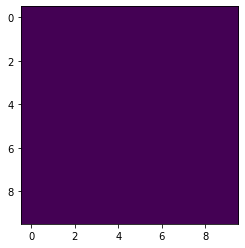

In [82]:
plt.imshow(np.array(threshed_chunks[20,5]))

In [83]:
size = 33
empty_c = np.array(empty_cell(size), dtype=np.uint8)
full_c = np.array(edge_cell(size), dtype=np.uint8)

In [84]:
font = ImageFont.truetype("MaisonNeue-Demi.otf", 90, encoding="unic")

In [85]:
cells = []
empty_tiles = np.tile(empty_c, (tile_size, tile_size))
id = 0
for j, col in enumerate(threshed_chunks):
    for i, cell in enumerate(col):
        s = cell.sum()
        if s > 0:
            render = empty_tiles - np.kron(cell, full_c)
            img = Image.fromarray(np.ones_like(render)*255)
            draw = ImageDraw.Draw(img)
            draw.text((size*5-100, 10), f"id:{id}", 
              fill=(0), font=font, spacing=0, align="left")
            draw.text((size*5-100, 110), f"x:{i}", 
              fill=(0), font=font, spacing=0, align="left")
            draw.text((size*5-100, 210), f"y:{j}", 
              fill=(0), font=font, spacing=0, align="left")
            label_render = np.array(img)
            del draw
            cells.append({"x": i, "y": j, "id": id, "render": render, 
                          "label_render": label_render, "cells": cell})
            id += 1
len(cells)

2876

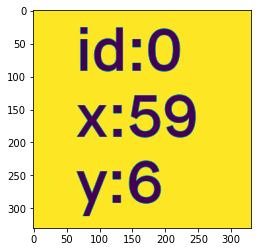

In [86]:
plt.imshow(cells[0]["label_render"])

In [87]:
fs = threshed_chunks.shape
sc = tile_size*size
full = np.full((fs[0]*sc,fs[1]*sc), 255, dtype=np.uint8)
 
for y in range(fs[0]):
  full[max(y*sc-1,0):y*sc+1, :] = 0
for x in range(fs[1]):
  full[:, max(x*sc-1,0):x*sc+1] = 0

In [88]:
for cell in cells:
  full[cell["y"]*sc:(cell["y"]+1)*sc, cell["x"]*sc:(cell["x"]+1)*sc] = cell["render"]

In [89]:
for y in range(0, fs[0], 2):
  full[max(y*sc-1,0):(y+1)*sc+1, :] -= np.minimum(12, full[max(y*sc-1,0):(y+1)*sc+1, :])
for x in range(0, fs[1], 2):
  full[:, max(x*sc-1,0):(x+1)*sc+1] -= np.minimum(12, full[:, max(x*sc-1,0):(x+1)*sc+1])

for y in range(0, fs[0], 10):
  full[max(y*sc-1,0):(y+1)*sc+1, :] -= np.minimum(12, full[max(y*sc-1,0):(y+1)*sc+1, :])
for x in range(0, fs[1], 10):
  full[:, max(x*sc-1,0):(x+1)*sc+1] -= np.minimum(12, full[:, max(x*sc-1,0):(x+1)*sc+1])

In [90]:
labels_full = np.full((fs[0]*sc,fs[1]*sc), 255, dtype=np.uint8)
for cell in cells:
    labels_full[cell["y"]*sc:(cell["y"]+1)*sc, cell["x"]*sc:(cell["x"]+1)*sc] = cell["label_render"]

In [91]:
labels_full_img = Image.fromarray(labels_full)
labels_full_img.save("fish/labels_full_fish.jpg")

In [92]:
full_img = Image.fromarray(full)

In [93]:
font_large = ImageFont.truetype("MaisonNeue-Mono.otf", 192, encoding="unic")

In [94]:
draw = ImageDraw.Draw(full_img)
for y in range(1, fs[0]-1):
  draw.text((60, y*sc+30), f"{y}", 
    fill=(0), font=font_large, align="left")
  draw.text((full.shape[1]-sc+40, y*sc+40), f"{y}", 
    fill=(0), font=font_large, align="left")
for x in range(1, fs[1]-1):
  draw.text((x*sc+40, 60), f"{x}",
    fill=(0), font=font_large, align="left")
  draw.text((x*sc+40, full.shape[0]-sc+40), f"{x}", 
    fill=(0), font=font_large, align="left")
del draw


In [95]:
!mkdir -p fish/tiles

In [96]:
full_img.save("fish/full_fish.jpg")

In [97]:
np.zeros((full.shape[0], full.shape[1], 4)).shape
labels_full

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [98]:
font_sm = ImageFont.truetype("MaisonNeue-Demi.otf", 40, encoding="unic")

In [99]:
for idx, cell in enumerate(cells):
  tile = np.full((sc+100, sc+100), 255, dtype=np.uint8)
  tile[80:80+sc, 80:80+sc] = cell["render"]
  img = Image.fromarray(tile)
  draw = ImageDraw.Draw(img)
  draw.text((15, 15), f"id:{cell['id']} x:{cell['x']} y:{cell['y']}", 
    fill=(0), font=font_sm, spacing=0, align="left")
  del draw
  num = str(idx).zfill(4)
  img.save(f"fish/tiles/tile_{num}.jpg")

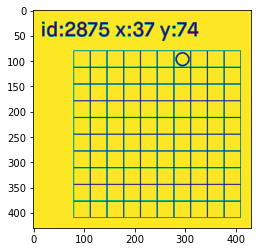

In [100]:
plt.imshow(img)

In [140]:
#!rm fish.zip
#!zip -rq fish.zip fish
#!rm -r fish
#!du -h fish.zip